<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li></ul></li><li><span><a href="#Общий-вывод-по-проекту" data-toc-modified-id="Общий-вывод-по-проекту-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод по проекту</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TimeSeriesSplit 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb

In [2]:
# загрузим данные, изменим индекс и тип данных и посмотрим их
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])


In [3]:
# размер данных
df.shape

(26496, 1)

In [4]:
# общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [7]:
# проверим в хронологическом ли порядке данные, да
df.index.is_monotonic

True

In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


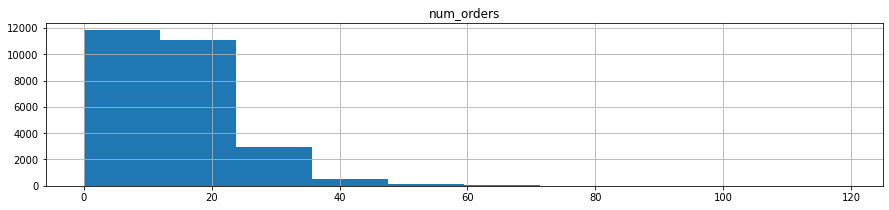

In [9]:
# посмотрим на данные
df.hist(figsize=(15, 3));

In [10]:
# проверим пропуски, их нет
df.isna().sum()

num_orders    0
dtype: int64

**Вывод по разделу**

- при загрузке данных изменили индекс, тип данных
- проверили, что данные в хронологическом ли порядке

Данные содержат 26496 строк 
- временной период 6 месяцев 2018 г. c 1 марта 2018 по 31 августа 2018 года (каждые 10 минут)
- в среднем 14 заказов, максимальное количество 119 заказов, стандартное отклонение 9 заказов, медиана 13 заказов
- пропусков нет

## Анализ

In [11]:
# изменим интервал до 1 часа
df = df.resample('1H').sum()

In [12]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


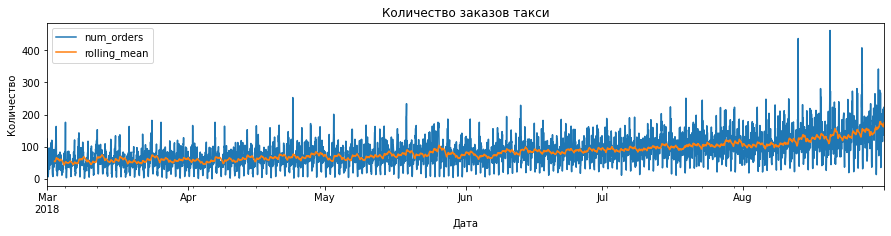

In [14]:
# Построим график заказов и скользящего среднего
df_rolling = df.copy()
df_rolling['rolling_mean'] = df_rolling.rolling(40).mean()
df_rolling.plot(figsize=(15, 3), title='Количество заказов такси', ylabel='Количество', xlabel='Дата');

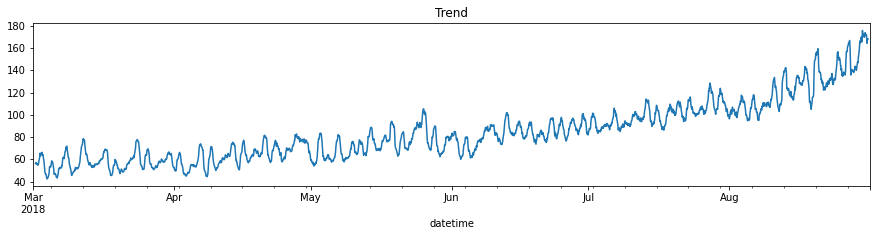

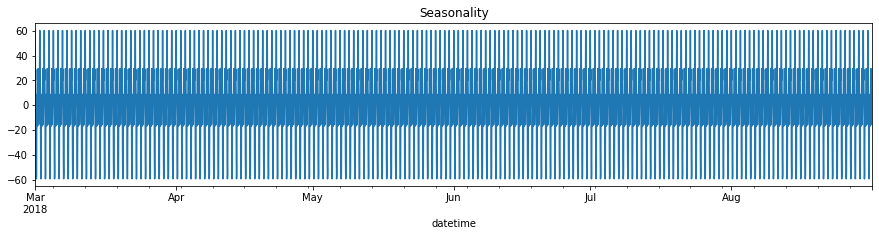

In [15]:
# Построим тренд и сезонную компоненту
decomposed = seasonal_decompose(df_rolling['num_orders'])
plt.figure(figsize=(15, 3))
plt.subplot()
decomposed.trend.plot()
plt.title('Trend');
plt.figure(figsize=(15, 3))
plt.subplot()
decomposed.seasonal.plot()
plt.title('Seasonality');

Виден тренд к увеличению заказов в течение полугода.
Сезонность имеется, но пока не понятна ее зависимость.
Рассмотрим меньший период.

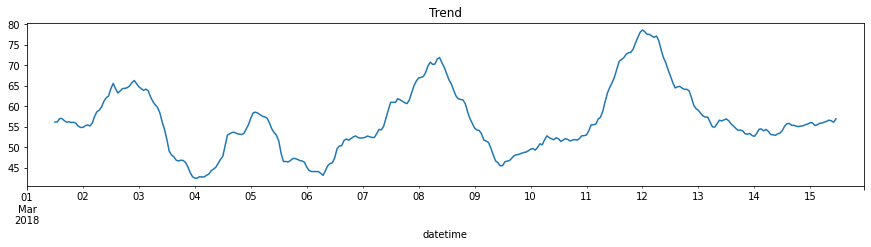

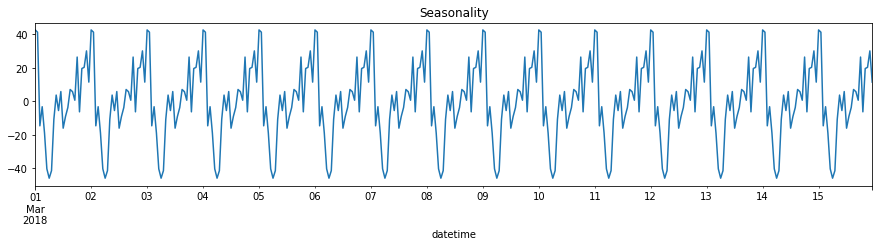

In [16]:
# Построим тренд и сезонную компоненту с 1 по 15 марта
df_seasonal = df_rolling['2018-03-01':'2018-03-15']
decomposed = seasonal_decompose(df_seasonal['num_orders'])
plt.figure(figsize=(15, 3))
plt.subplot()
decomposed.trend.plot()
plt.title('Trend');
plt.figure(figsize=(15, 3))
plt.subplot()
decomposed.seasonal.plot()
plt.title('Seasonality');

При уменьшении периода до полумесяца тренд теряется, но видна сезонность в пределах суток. 
Рассмотрим еще более мелкий период.

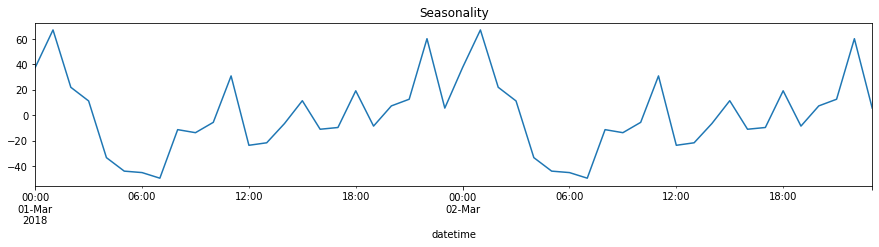

In [17]:
# Построим сезонную компоненту с 1 по 2 марта
df_seasonal = df_rolling['2018-03-01':'2018-03-02']
decomposed = seasonal_decompose(df_seasonal['num_orders'])
plt.figure(figsize=(15, 3))
plt.subplot()
decomposed.seasonal.plot()
plt.title('Seasonality');

Видна сезонность в течении суток, спад заказов к 6-7 часам утра и ежедневный рост с 10 вечера до 1 ночи.

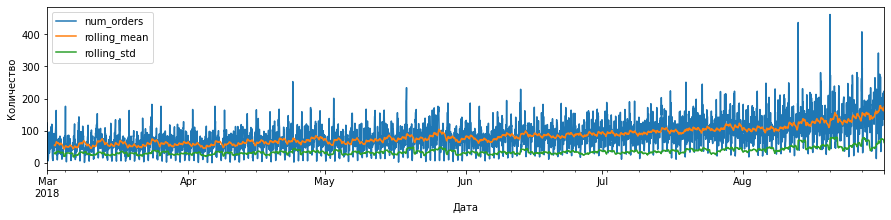

In [18]:
# Рассмотрим стационарный наш ряд или нет, найдём скользящее стандартное отклонение
df_rolling['rolling_std'] = df_rolling['num_orders'].rolling(40).std()
df_rolling.plot(figsize=(15, 3), ylabel='Количество', xlabel='Дата');

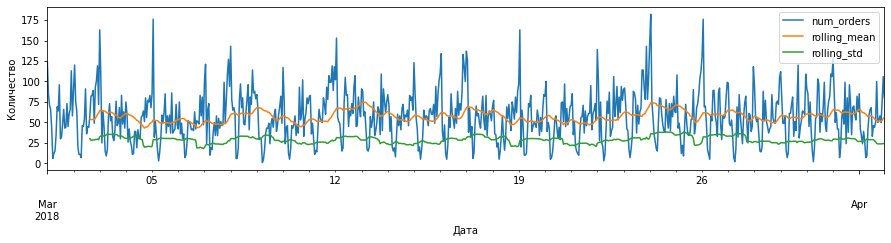

In [19]:
df_rolling['2018-03-01':'2018-04-01'].plot(figsize=(15, 3), ylabel='Количество', xlabel='Дата');

Так как стационарные временные ряды  это ряды, у которых среднее и стандартное отклонение не меняются, то за полный период данных (полгода) когда видет тренд, меняется среднее и отклонения и временной ряд можно назвать нестационарным.

А если рассматривать временной период (месяц) за который видна сезонность, то можно сказать, что такой ряд стационарный, так среднее и отклонения не меняются.

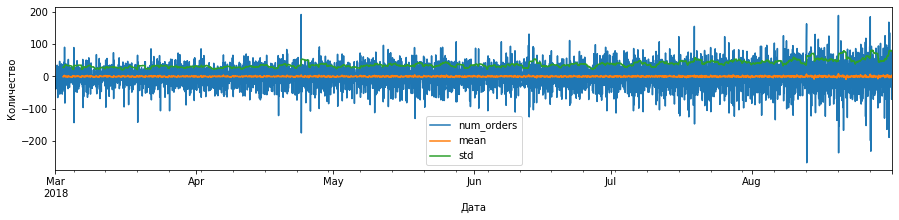

In [20]:
# Чтобы ряд сделать стационарным, найдём разности его значений
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(40).mean()
df_shift['std'] = df_shift['num_orders'].rolling(40).std()
df_shift.plot(figsize=(15, 3), ylabel='Количество', xlabel='Дата');

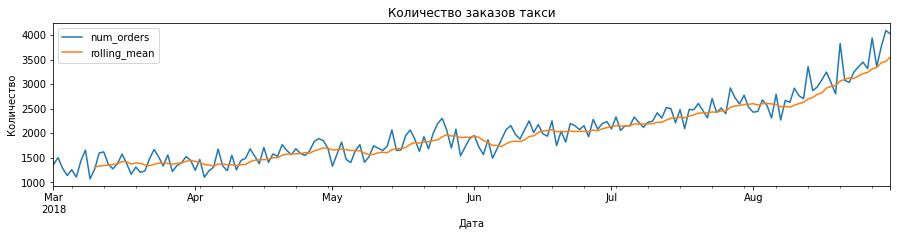

In [22]:
# Исследуем недельную сезонность
# изменим интервал до 1 дня
df_day = df.resample('1D').sum()
# Построим график заказов и скользящего среднего
df_day['rolling_mean'] = df_day.rolling(10).mean()
df_day.plot(figsize=(15, 3), title='Количество заказов такси', ylabel='Количество', xlabel='Дата');

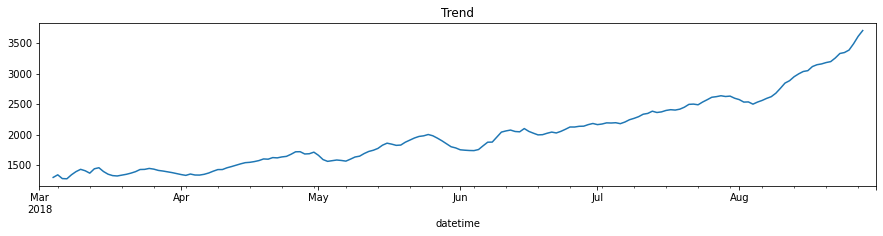

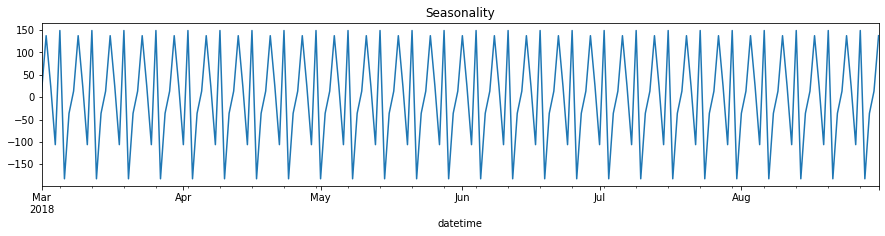

In [23]:
# Построим тренд и сезонную компоненту
decomposed = seasonal_decompose(df_day['num_orders'])
plt.figure(figsize=(15, 3))
plt.subplot()
decomposed.trend.plot()
plt.title('Trend');
plt.figure(figsize=(15, 3))
plt.subplot()
decomposed.seasonal.plot()
plt.title('Seasonality');

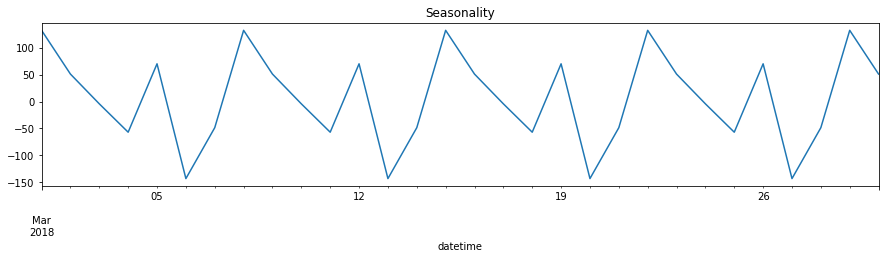

In [24]:
# Построим сезонную компоненту за 1 месяца
df_day = df_day['2018-03-01':'2018-03-30']
decomposed = seasonal_decompose(df_day['num_orders'])
plt.figure(figsize=(15, 3))
plt.subplot()
decomposed.seasonal.plot()
plt.title('Seasonality');

На графике видна недельная сезонность в течении суток, спад заказов по понедельникам и рост по средам и воскресеньям.

**Вывод по разделу**

Провели ресемплирование по одному часу
- данных стало 4416 строк
- в среднем за час 84 заказа, максимальное количество 462 заказа, стандартное отклонение 45 заказов, медиана 78 заказов
- построили график заказов и скользящего среднего
- построили тренд и сезонную компоненту
    - виден тренд к увеличению заказов в течении полугода
    - и сезонность в течении суток, спад заказов к 6-7 часам утра и ежедневный рост с 10 вечера до 1 ночи.
- за полный период данных (полгода) временной ряд можно назвать нестационарным, а если рассматривать временной период (месяц), то можно сказать, что такой ряд стационарный, так среднее и отклонения не меняются.
- можно ряд сделать стационарным, найдя разности его значений
- исследовали недельную сезонность, выявлено, что есть недельная сезонность в течении суток, спад заказов по понедельникам и рост по средам и воскресеньям.

## Обучение

### Подготовка данных

У данных выявлена суточная и недельная сезонность, поэтому дополнительные признаки будут час и день недели.

In [26]:
# cоздадим признаки для горизонта прогнозирования, напишем функцию для создания признаков
def make_features(data, max_lag=0, rolling_mean_size=0):
    # календарные признаки
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    # отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() 

In [27]:
make_features(df, 24, 7)
df

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,167.428571
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.428571
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.714286


In [28]:
# разделим данные на выборки 90/10
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [29]:
# удалим значения признаков с NaN
train = train.dropna()

In [30]:
# проверим деление
train.shape, test.shape, train.index.min(), train.index.max(), test.index.min(), test.index.max()

((3950, 28),
 (442, 28),
 Timestamp('2018-03-02 00:00:00', freq='H'),
 Timestamp('2018-08-13 13:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [31]:
# выделим признаки
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

In [32]:
# выделим целевой признак
target_train = train['num_orders']
target_test = test['num_orders']

In [33]:
# проверим деление
features_train.shape, features_test.shape, target_train.shape, target_test.shape, 

((3950, 27), (442, 27), (3950,), (442,))

### Модель линейной регрессии

In [34]:
%%time
# Обучим модель линейной регрессии через кросс валидацию
model = LinearRegression()
scores = cross_validate(model, features_train, target_train, \
                        scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=3), n_jobs=-1)
print('RMSE: ', round(abs(scores['test_score'].mean()), 3))
rmse = []
rmse.append(round(abs(scores['test_score'].mean()), 3))

RMSE:  27.773
CPU times: user 170 ms, sys: 474 ms, total: 643 ms
Wall time: 573 ms


### Модель CatBoost

In [35]:
%%time
# Обучим модель градиентного бустинга CatBoost. В данной моделе будем менять гиперпараметры:
# максимальную глубину дерева - depth, скорость обучения - learning_rate
model = CatBoostRegressor(iterations=200)
parameters = [{'depth':[6, 8], 'learning_rate':[0.3, 0.5]}]
grid = GridSearchCV(estimator=model, param_grid=parameters, \
                    scoring='neg_root_mean_squared_error', cv = TimeSeriesSplit(n_splits=3), n_jobs=-1)
grid.fit(features_train, target_train, verbose=False)
print('RMSE: ', round(abs(grid.best_score_), 3))
print('Лучшие параметры: ', grid.best_params_)
rmse.append(round(abs(grid.best_score_), 3))

RMSE:  26.489
Лучшие параметры:  {'depth': 6, 'learning_rate': 0.3}
CPU times: user 31 s, sys: 515 ms, total: 31.5 s
Wall time: 56.4 s


### Модель LightGBM

In [36]:
%%time
# Обучим модель градиентного бустинга LightGBM. В данной моделе будем менять гиперпараметры:
# n_estimators - число деревьев , num_leaves - максимальное количество листьев, 
# максимальную глубину дерева - max_depth, скорость обучения - learning_rate
model = lgb.LGBMRegressor()
parameters = {'n_estimators': [8, 10],
              'num_leaves': [8,10],
              'max_depth':[2,4],
             'learning_rate':[0.3, 0.5] }
grid = GridSearchCV(estimator=model, param_grid=parameters, \
                    scoring='neg_root_mean_squared_error', cv = TimeSeriesSplit(n_splits=3), n_jobs=-1)
grid.fit(features_train, target_train)
print(f'RMSE:  {(-grid.best_score_):.3f}')
print(f'Лучшие гиперпараметры:  {grid.best_params_}')
rmse.append(round(abs(grid.best_score_), 3))

RMSE:  26.667
Лучшие гиперпараметры:  {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 10, 'num_leaves': 8}
CPU times: user 4min 55s, sys: 3.7 s, total: 4min 59s
Wall time: 5min


In [37]:
df_total = pd.DataFrame({'Модель':['Линейная регрессия', 'Модель CatBoost', 'Модель LightGBM'], 'RMSE':rmse})
df_total

,Модель,RMSE
0,Линейная регрессия,27.773
1,Модель CatBoost,26.489
2,Модель LightGBM,26.667


**Вывод по разделу**

Подготовили данные:
- добавили дополнительные календарные признаки: час и день недели
- добавили отстающие значения (24)
- добавили скользящее среднее (7)
- разделим данные на выборки 90/10
- проверели деление данных: количество и временной период

Обучили три модели, с использованием кросс валидации и подбора параметров GridSearchCV, выбрали лучшие параметры и оценили качество моделей.

Наилучший результат показала Модель  CatBoost с параметрами: {'depth': 6, 'learning_rate': 0.3}

наилучшая RMSE = 26.489

## Тестирование

### Проверка модели на тестовой выборке

In [43]:
%%time
model = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.3)
model.fit(features_train, target_train, verbose=False)
predicted_test = model.predict(features_test)
rmse_test = mean_squared_error(target_test, predicted_test)**0.5
print('Тестовая выборка')
print('RMSE: ', round(rmse_test, 3))

Тестовая выборка
RMSE:  39.929
CPU times: user 1.56 s, sys: 60.2 ms, total: 1.62 s
Wall time: 3.42 s


### Проверка модели на адекватность

In [39]:
# Cпрогнозируем временной ряд без обучения, это будет проверкой на адекватность и служить ориентиром

# 1 способ: все значения тестовой выборки предсказываются одним и тем же числом (константой), возмем медиану
print("Среднее количество заказов такси в час:", round(test['num_orders'].mean(), 3))
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('RMSE: ', round(mean_squared_error(test, pred_median)**0.5, 3))

Среднее количество заказов такси в час: 139.557
RMSE:  85.271


In [40]:
# 2 способ: новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1)
print("Среднее количество заказов такси в час:", round(test['num_orders'].mean(), 3))
pred_previous = test.shift(fill_value=train.iloc[-1, 0])
print('RMSE: ', round(mean_squared_error(test, pred_previous)**0.5, 3))

Среднее количество заказов такси в час: 139.557
RMSE:  56.31


In [41]:
%%time
# 3 способ: модель Dummy
dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
prediced_dummy = dummy.predict(features_test)
rmse_dummy = mean_squared_error(target_test, prediced_dummy)**0.5
print('Dummy модель')
print('RMSE: ', round(rmse_dummy, 3))

Dummy модель
RMSE:  84.65
CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 1.37 ms


В качестве сравнения выберем лучшую костантную модель (по 2 способу)

In [42]:
df_total_t = pd.DataFrame({'Модель':['Модель CatBoost Обучающая', 'Модель CatBoost Тестовая', \
                                     'Лучшая Константная модель'], \
                           'RMSE': [rmse[1], round(rmse_test, 3), round(mean_squared_error(test, pred_previous)**0.5, 3)]})
df_total_t

,Модель,RMSE
0,Модель CatBoost Обучающая,26.489
1,Модель CatBoost Тестовая,42.671
2,Лучшая Константная модель,56.310


**Вывод по разделу:**

В результате проверки наилучшей модели на тестовой выборке данные улучшились.
- RMSE тестовой выборки: 42.671


Также в результате сравнения с константной моделью видны лучшие характеристики нашей модели.
Соответственно работа выполнена, модель обучена и проверена.

## Общий вывод по проекту

Проанализировав данные компании «Чётенькое такси» о заказах такси в аэропортах. Была выбрана лучшая модель, и проверено её качество на тестовой выборке.
Ей стала Модель CatBoost с параметрами: {'depth': 8, 'learning_rate': 0.3}


В 1 разделе: 
- что данные в хронологическом ли порядке
- данные содержат 26496 строк 
- временной период 6 месяцев 2018 г. c 1 марта 2018 по 31 августа 2018 года (каждые 10 минут)
- в среднем 14 заказов, максимальное количество 119 заказов, стандартное отклонение 9 заказов, медиана 13 заказов
- пропусков нет

Во 2 разделе:
- провели ресемплирование по одному часу
- данных стало 4416 строк
- в среднем за час 84 заказа, максимальное количество 462 заказа, стандартное отклонение 45 заказов, медиана 78 заказов
- построили график заказов и скользящего среднего
- построили тренд и сезонную компоненту
    - виден тренд к увеличению заказов в течении полугода
    - и сезонность в течении суток, спад заказов к 6-7 часам утра и ежедневный рост с 10 вечера до 1 ночи.
- за полный период данных (полгода) временной ряд можно назвать нестационарным, а если рассматривать временной период (месяц), то можно сказать, что такой ряд стационарный, так среднее и отклонения не меняются.
- можно ряд сделать стационарным, найдя разности его значений
- исследовали недельную сезонность, выявлено, что есть недельная сезонность в течении суток, спад заказов по понедельникам и рост по средам и воскресеньям.

В 3 разделе:
- подготовили данные:
- добавили дополнительные календарные признаки: час и день недели
- добавили отстающие значения (24)
- добавили скользящее среднее (7)
- разделим данные на выборки 90/10
- проверели деление данных: количество и временной период
Обучили три модели, с использованием кросс валидации и подбора параметров GridSearchCV, выбрали лучшие параметры и оценили качество моделей.

Наилучший результат показала Модель  CatBoost с параметрами: {'depth': 6, 'learning_rate': 0.3}

наилучшая RMSE = 26.489

В 4 разделе:
В результате проверки наилучшей модели на тестовой выборке данные улучшились.
- RMSE тестовой выборки: 42.671
Также в результате сравнения с константной моделью видны лучшие характеристики нашей модели.
Соответственно работа выполнена, модель обучена и проверена.
